22210802 Haeeul Hwang



**1. How is the TTR (type-token ratio) defined? Why is this a ‘good’ measure of the morphological complexity? Which other metric could you use to quantify morphological complexity?**

- The Type-Token Ratio (TTR) is a measure used in linguistics to assess lexical diversity or richness in a given text. It is defined as the ratio of unique words (types) to the total number of words (tokens) in a text.

- TTR is often considered a useful measure of morphological complexity because languages with rich morphology tend to generate more word forms from a single root (e.g., through inflection, derivation, etc.), increasing the number of types in the text. Higher TTR indicates a more diverse vocabulary, suggesting a greater use of word variations, which can imply a more morphologically rich language.

- For example, MCI (Morphological Complexity Idex) could be used to quantify morphological complexity. This is a more nuanced measure that looks at the number of morphemes per word, capturing both the derivational and inflectional morphology of a language.





**2. Why do we consider a language modeling task?**

- A language model is a fundamental tool in NLP because it captures the statistical and probabilistic properties of a language. By leveraging shared linguistic patterns across languages, a language model can help in languages with limited training data (low-resource languages).

**3. How is the perplexity defined? Can we compare perplexity across corpora or languages? Conclude.**

- Perplexity is a measurement of how well a probabilistic model predicts a sample of data. Specifically, it is the exponentiation of the average negative log-probability assigned to a sequence by a language model.

  Formally, for a sequence of words $𝑊 = 𝑤_1 , 𝑤_2 , . . . , 𝑤_𝑛$, the perplexity 𝑃𝑃(𝑊) of a model 𝑀 is defined as:

  $$PP(W) = 2^{-\frac{1}{n} \sum_{i=1}^{n} \log_2 P(w_i \mid w_1, w_2, \dots, w_{i-1})}$$

  Where:
  - 𝑛 is the total number of words in the sequence.
  - $𝑃 ( 𝑤_𝑖 ∣ 𝑤_1 , . . . , 𝑤_𝑖 − 1 )$ is the probability assigned by the model to the word $𝑤_𝑖$, given the preceding words.

    Lower perplexity indicates better performance, meaning the model's predictions align more closely with the true distribution of the data.

- Perplexity is a useful metric for evaluating how well a language model performs within a given corpus or language, but it is not directly comparable across corpora or languages due to differences in vocabulary, tokenization, and linguistic structure. To make meaningful comparisons between languages or corpora, other normalization techniques or complementary metrics (e.g., BLEU for machine translation or cross-lingual language modeling benchmarks) should be considered alongside perplexity.

**4. What conclusions can you draw from Figure 1.**

- Perplexity varies depending on language.
- Languages ​​that are morphologically similar are distributed closely together on the graph.
- There appears to be a correlation between perplexity and ttr. The higher the TTR, the higher the perplexity. This suggests that in morphologically complex languages, the model has a harder time predicting the next word than in less complex languages.

**5. Why will we not consider the corpus used in [1]? Why are the FAIR principles a solution
to this problem?**

- The source of this corpus is inconsistent, as it is from either Wikipedia or polyglot Wikipedia depending on the language. This inconsistency can lead to issues in data reliability, reproducibility, and comparability across languages or experiments.

- The FAIR principles help address the inconsistency between using Wikipedia or Polyglot Wikipedia as data sources by ensuring that the corpus is well-documented, accessible, interoperable, and reusable. Applying these principles ensures transparency in data origin and preparation, allows users to track differences between language sources, and supports cross-linguistic research by harmonizing formats and metadata. This makes the corpus more reliable and comparable, even when sourced from different repositories.

In [65]:
import tensorflow_datasets as tfds
from itertools import islice

ds = tfds.load("wiki40b/fr", split="test", data_dir="gs://tfds-data/datasets")
sample = [ex["text"].numpy().decode("utf-8")
    for ex in islice(ds.shuffle(buffer_size=10_000), 100)]

In [61]:
%%capture
!pip install pyicu
!pip install pycld2
!pip install morfessor
!pip install polyglot
!pip install https://github.com/kpu/kenlm/archive/master.zip

In [62]:
import os
import kenlm
import re
import tensorflow_datasets as tfds
import random
import polyglot
from polyglot.text import Text, Word
import string
import pandas as pd
from pathlib import Path
from polyglot.detect.base import logger as polyglot_logger
polyglot_logger.setLevel("ERROR")

**6. What is the role of the data_dir parameter in line 4 of Figure 2? What is the meaning of its value?**

- The data_dir parameter specifies the directory where the training data is stored. The value of this parameter is the path to the directory containing the training data files, which the language model will use to learn the statistical properties of the language.

**7. Why do we use the islice function in line 6 of Figure 2?**

- We use the islice function (from Python's itertools module) to slice an iterable (like a list, generator, or any other iterable object) without needing to convert it into a list. This is particularly useful when dealing with large datasets or infinite iterators because it allows you to efficiently extract a specific portion (a "slice") of the iterable without loading the entire iterable into memory.

**8. Why do we consider the test set (see the split parameter)? Is this a good idea?**

- Normally It is smaller than the train set, so it's efficient to use.


**9. Why do we have to specify a buffer_size parameter for the shuffle method? How do we choose its value?**

- The buffer_size parameter in the shuffle method determines the number of elements to sample from the dataset before shuffling. This parameter is important for ensuring that the data is shuffled effectively, especially when working with large datasets that do not fit into memory.

- We choose the value of buffer_size based on the size of the dataset and the available memory. A larger buffer_size can lead to better shuffling but requires more memory, while a smaller buffer_size may be faster but less effective in shuffling the data. It is often recommended to set buffer_size to a value that is large enough to shuffle the data effectively but not so large that it causes memory issues.

**10. Why do we have to extract sentences out of Wikipedia articles?**

- Sentences from Wikipedia articles provide meaningful context for the language model to capture syntactic and semantic patterns, making it easier to predict the next word in a sequence.

**11. Why do we enforce that all train and test sets have the same size?**

- Enforcing that all train and test sets have the same size ensures that the evaluation of the language model is consistent across different datasets. By using the same number of samples in the training and test sets, we can compare the model's performance more accurately and avoid biases that may arise from imbalanced dataset sizes.

**12. What kind of information polyglot is using to identify sentence boundaries and segment
sentences into tokens. Comment.**

- Polyglot uses a combination of linguistic rules and statistical models to identify sentence boundaries and segment sentences into tokens. It leverages language-specific knowledge about punctuation, capitalization, and other linguistic features to determine sentence boundaries. Additionally, Polyglot may use machine learning algorithms to learn patterns in the text data and predict sentence boundaries based on these patterns.

**13. For each languages of the corpus extract a train set of 40,000 sentences and a test set of 3,000 sentences. Sentences must be unique (i.e. if there are several occurrences of an identical sentence, they must all be removed but one).**

In [63]:
# Define function to extract unique sentences
def extract_unique_sentences(ds, total_sentences):
    unique_sentences = set()

    for ex in ds:
        ex = Text(ex)
        for sentence in ex.sentences:
            if len(sentence.words) == 1 or sentence.startswith("_") :
                continue
            else: # Remove all occurrences of "_NEWLINE_"
                sentence = sentence.replace("_NEWLINE_", "")
                sentence = sentence.strip()

                if sentence and sentence not in unique_sentences:
                    unique_sentences.add(str(sentence))

                # Stop once we've collected enough unique sentences
                if len(unique_sentences) >= total_sentences:
                    return list(unique_sentences)

    # Return unique sentences collected
    return list(unique_sentences)


# Load and process the dataset for each language
def process_language(language_code, train_size=40000, test_size=3000):
    total_required = train_size + test_size

    ds = tfds.load(f"wiki40b/{language_code}", split="train", data_dir="gs://tfds-data/datasets")
    sample = [ex["text"].numpy().decode("utf-8")
        for ex in islice(ds.shuffle(buffer_size=10_000), 10_000)]

    unique_sentences = extract_unique_sentences(sample, total_required)

    # Split the data into train and test sets
    train_sentences = unique_sentences[:train_size]
    test_sentences = unique_sentences[train_size:train_size+test_size]

    return train_sentences, test_sentences

In [66]:
languages = ["en", "ar", "zh-cn", "zh-tw", "nl", "fr", "de", "it",
             "ja", "ko", "pl", "pt", "ru", "es", "th", "tr", "bg",
             "ca", "cs", "da", "el", "et", "fa", "fi", "he", "hi",
             "hr", "hu", "id", "lt", "lv", "ms", "no", "ro", "sk",
             "sl", "sr", "sv", "tl", "uk", "vi"]

results = {}

for lang in languages:
    print(f"Processing language: {lang}")
    train_set, test_set = process_language(lang)

    if train_set and test_set:
        results[lang] = {
            "train": train_set,
            "test": test_set
        }

Processing language: en
Processing language: ar
Processing language: zh-cn
Processing language: zh-tw
Processing language: nl
Processing language: fr
Processing language: de
Processing language: it
Processing language: ja
Processing language: ko
Processing language: pl
Processing language: pt
Processing language: ru
Processing language: es
Processing language: th
Processing language: tr
Processing language: bg
Processing language: ca
Processing language: cs
Processing language: da
Processing language: el
Processing language: et
Processing language: fa
Processing language: fi
Processing language: he
Processing language: hi
Processing language: hr
Processing language: hu
Processing language: id
Processing language: lt
Processing language: lv
Processing language: ms
Processing language: no
Processing language: ro
Processing language: sk
Processing language: sl
Processing language: sr
Processing language: sv
Processing language: tl
Processing language: uk
Processing language: vi


**14. Why do we have to remove duplicate sentences?**

- Removing duplicate sentences is important to ensure that the language model does not learn redundant information from the training data. Duplicate sentences can bias the model's predictions and lead to overfitting, where the model memorizes specific examples rather than learning general patterns in the language. By removing duplicates, we can improve the diversity and quality of the training data, leading to better language model performance.

**15. Using polyglot tokenize all datasets into words. Save each dataset into a separate text file (one sentence per line) using consistent names to be able to automate the LM estimation (see Section 2.3).**

In [67]:
# Define function to tokenize and save sentences from the dataset
def tokenize_and_save(sentences, language_code, output_dir, dataset_type):
    output_dir = Path("/content/drive/MyDrive/NLP")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Define the output file path
    output_file = output_dir / f"{language_code}_{dataset_type}.txt"

    with output_file.open('w', encoding='utf-8') as file:
        for sentence in sentences:

            # Tokenize the sentence using Polyglot
            polyglot_text = Text(sentence, hint_language_code=language_code)
            tokenized_sentence = ' '.join(polyglot_text.words)

            # Write the tokenized sentence to the output file
            file.write(tokenized_sentence + '\n')

# Process datasets and save tokenized sentences for each language
def process_datasets(datasets_dict, output_base_dir=Path("/content/drive/MyDrive/NLP")):
    for language_code, data in datasets_dict.items():
        print(f"Processing language: {language_code}")

        # Define the output directory for the language
        language_output_dir = Path(output_base_dir) / language_code

        # Tokenize and save train sentences
        tokenize_and_save(data['train'], language_code, language_output_dir, 'train')

        # Tokenize and save test sentences
        tokenize_and_save(data['test'], language_code, language_output_dir, 'test')

In [68]:
process_datasets(results)

Processing language: en
Processing language: ar
Processing language: zh-cn
Processing language: zh-tw
Processing language: nl
Processing language: fr
Processing language: de
Processing language: it
Processing language: ja
Processing language: ko
Processing language: pl
Processing language: pt
Processing language: ru
Processing language: es
Processing language: th
Processing language: tr
Processing language: bg
Processing language: ca
Processing language: cs
Processing language: da
Processing language: el
Processing language: et
Processing language: fa
Processing language: fi
Processing language: he
Processing language: hi
Processing language: hr
Processing language: hu
Processing language: id
Processing language: lt
Processing language: lv
Processing language: ms
Processing language: no
Processing language: ro
Processing language: sk
Processing language: sl
Processing language: sr
Processing language: sv
Processing language: tl
Processing language: uk
Processing language: vi


**16. Compute the TTR for all datasets**

In [69]:
lang_ttr = dict()

for lang in languages:
  txt = ""
  for path in Path("/content/drive/MyDrive/NLP").glob(f"{lang}_*.txt"):
    with path.open('r', encoding='utf-8') as f:
      txt += f.read()
      txt = txt.translate(str.maketrans('', '', string.punctuation)).lower()
      tokens = txt.split()
      unique_types = len(set(tokens))
      total_tokens = len(tokens)
      lang_ttr[lang] = unique_types / total_tokens

In [ ]:
lang_ttr

{'en': 0.06784785743932192,
 'ar': 0.13647329200715766,
 'zh-cn': 0.0452037030068805,
 'zh-tw': 0.05350165052838155,
 'nl': 0.09808550453433136,
 'fr': 0.08341840438072343,
 'de': 0.1320223203041606,
 'it': 0.08799646515294927,
 'ja': 0.04656277875435751,
 'ko': 0.2806948586683266,
 'pl': 0.16182450687348895,
 'pt': 0.077306727490428,
 'ru': 0.16797429609278483,
 'es': 0.07604912677472045,
 'th': 0.02354205252410125,
 'tr': 0.17544438100758178,
 'bg': 0.11607375160795656,
 'ca': 0.07976838931757489,
 'cs': 0.16577943507275192,
 'da': 0.11524397267250723,
 'el': 0.10708002008721319,
 'et': 0.2118226320150201,
 'fa': 0.07526050377373122,
 'fi': 0.23623492605687196,
 'he': 0.15583628110203165,
 'hi': 0.07859258951708036,
 'hr': 0.1545770622975805,
 'hu': 0.181158338423025,
 'id': 0.08257062533502127,
 'lt': 0.17947161989304483,
 'lv': 0.1490442499425062,
 'ms': 0.07999554912651607,
 'no': 0.11820168244446527,
 'ro': 0.09555613157293966,
 'sk': 0.1698665586459017,
 'sl': 0.1461515272587231

**17. Knowing that you will have to compute for each language its TTR and its perplexity, what is the best way to store the TTR?**

In [70]:
df = pd.DataFrame(columns=['Lang_code', 'TTR', 'Perplexity'])
df['Lang_code'] = languages
df['TTR'] = lang_ttr.values()

df

,Lang_code,TTR,Perplexity
0,en,0.067503,NaN
1,ar,0.136828,NaN
2,zh-cn,0.044721,NaN
3,zh-tw,0.052996,NaN
4,nl,0.098723,NaN
5,fr,0.082807,NaN
6,de,0.133760,NaN
7,it,0.087939,NaN
8,ja,0.046549,NaN
9,ko,0.281317,NaN


**18. Classify each language of the wiki40b corpus into one of the following four categories to characterize its morphology: isolating, fusional, introflexive and agglutinative. You can/should use a typological database such as the WALS.**



In [71]:
morpho = [ "Fusional", "Introflexive", "Isolating", "Isolating", "Fusional", "Fusional", "Fusional", "Fusional", "Agglutinative",
          "Agglutinative", "Fusional", "Fusional", "Fusional", "Fusional", "Isolating", "Agglutinative", "Fusional", "Fusional", "Fusional",
           "Fusional", "Fusional", "Agglutinative", "Fusional", "Agglutinative", "Introflexive", "Fusional", "Fusional", "Agglutinative",
           "Fusional", "Fusional", "Agglutinative", "Fusional", "Fusional", "Fusional", "Fusional", "Fusional", "Fusional", "Fusional", "Isolating",
           "Fusional", "Isolating" ]

df['Morphology'] = morpho
df

,Lang_code,TTR,Perplexity,Morphology
0,en,0.067503,NaN,Fusional
1,ar,0.136828,NaN,Introflexive
2,zh-cn,0.044721,NaN,Isolating
3,zh-tw,0.052996,NaN,Isolating
4,nl,0.098723,NaN,Fusional
5,fr,0.082807,NaN,Fusional
6,de,0.133760,NaN,Fusional
7,it,0.087939,NaN,Fusional
8,ja,0.046549,NaN,Agglutinative
9,ko,0.281317,NaN,Agglutinative


**19. What structure should you use to store this information? Why?**

- I used pandas dataframe structure because it is useful tool to manipulate the data.

**20. Install kenlm using the instructions provided in Figure 3**

In [ ]:
!git clone https://github.com/kpu/kenlm.git
%cd kenlm
!python setup.py develop
!mkdir -p build
%cd build
!cmake ..
!make -j 4

**21 .Why do some shell commands in Figure 3 starts with a ! and others with a %?**

- In Python, especially in environments like Jupyter notebooks, commands starting with ! and % are used for different purposes.

- The ! is used to execute shell commands directly from a Jupyter notebook or a Python script. Any command that would normally be run in a terminal or shell can be run this way within a notebook.

- The % is used for magic commands, which are special commands in Jupyter that are specific to the notebook environment. These commands do not exist in the shell but are useful within the notebook context. Magic commands are designed to make tasks related to the notebook itself easier, such as changing the directory, timing code execution, or managing variables.

**22. Why the python interface of kenlm allows you to compute the perplexity of a model but not to estimate its parameters?**

- The Python interface of KenLM is designed for inference tasks, like computing perplexity, which are more lightweight and can be efficiently handled in Python. In contrast, training (parameter estimation) is a resource-intensive task and is left to the more optimized C++ implementation, which is suited for large-scale data processing.

**23. Using a for-loop, train a language model for each languages**

In [72]:
data_dir = "/content/drive/MyDrive/NLP"

for lang in languages:
  input_file= os.path.join(data_dir, f'{lang}_train.txt')
  output_file = f'/content/drive/MyDrive/NLP/{lang}_train.arpa'

  cmd= f'./bin/lmplz -o 5 < {input_file} > {output_file}'
  os.system(cmd)

**24. Estimate for each language, the perplexity of the LM and store it into a well-chosen structure.**

In [73]:
for lang in languages:
  model_path= f'/content/drive/MyDrive/NLP/{lang}_train.arpa'
  model = kenlm.LanguageModel(model_path)
  ppl_lang = 0
  nb_sentences = 0
  test_file = os.path.join("/content/drive/MyDrive/NLP", f'{lang}_test.txt')

  with open(test_file, 'r', encoding= 'utf-8') as file:
    test_sentences = file.readlines()
    for sentence in test_sentences:
      nb_sentences +=1
      ppl_sent = model.perplexity(sentence)
      ppl_lang+=ppl_sent

  ppl_lang= ppl_lang/nb_sentences
  df.loc[df['Lang_code'] == lang, 'Perplexity'] = ppl_lang

In [74]:
df

,Lang_code,TTR,Perplexity,Morphology
0,en,0.067503,1101.872424,Fusional
1,ar,0.136828,3422.922598,Introflexive
2,zh-cn,0.044721,1280.431786,Isolating
3,zh-tw,0.052996,1393.025332,Isolating
4,nl,0.098723,1173.39176,Fusional
5,fr,0.082807,1180.755354,Fusional
6,de,0.133760,1124.447952,Fusional
7,it,0.087939,1729.800013,Fusional
8,ja,0.046549,616.088398,Agglutinative
9,ko,0.281317,6486.4469,Agglutinative


**25. Plot the results of the previous two sections to reproduce the result reported in Figure 1. To ensure that all language have the same vocabulary size, we can consider the BPE tokenization.**

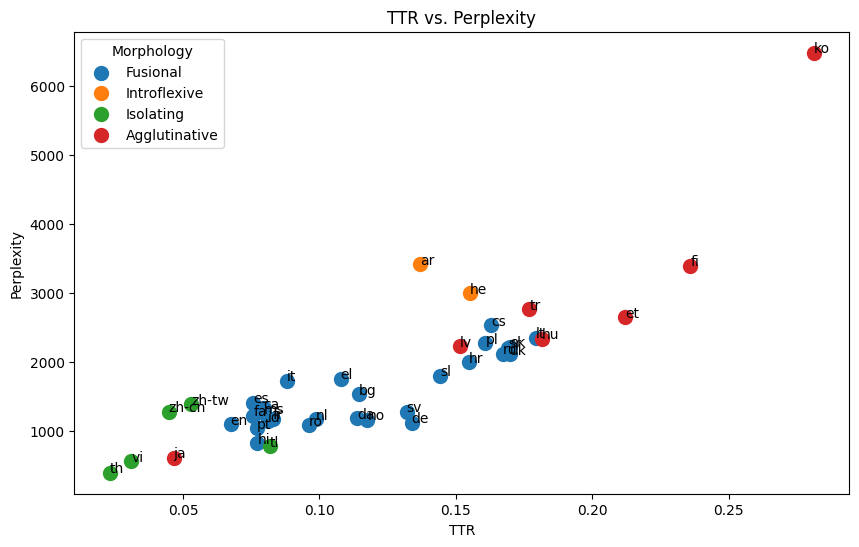

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for morphology in df['Morphology'].unique():
  subset = df[df['Morphology'] == morphology]
  plt.scatter(subset['TTR'], subset['Perplexity'], label=morphology, s=100)
  for i, txt in enumerate(subset['Lang_code']):
    plt.annotate(txt, (subset['TTR'].iloc[i], subset['Perplexity'].iloc[i]))

plt.xlabel('TTR')
plt.ylabel('Perplexity')
plt.title('TTR vs. Perplexity')
plt.legend(title='Morphology')
plt.grid(False)
plt.show()


**26. Install sentencepiece and tokenize all datasets using a vocabulary size of 32,000 tokens**

- I had to set the vocabulary size to 21438 because of this runtime error.

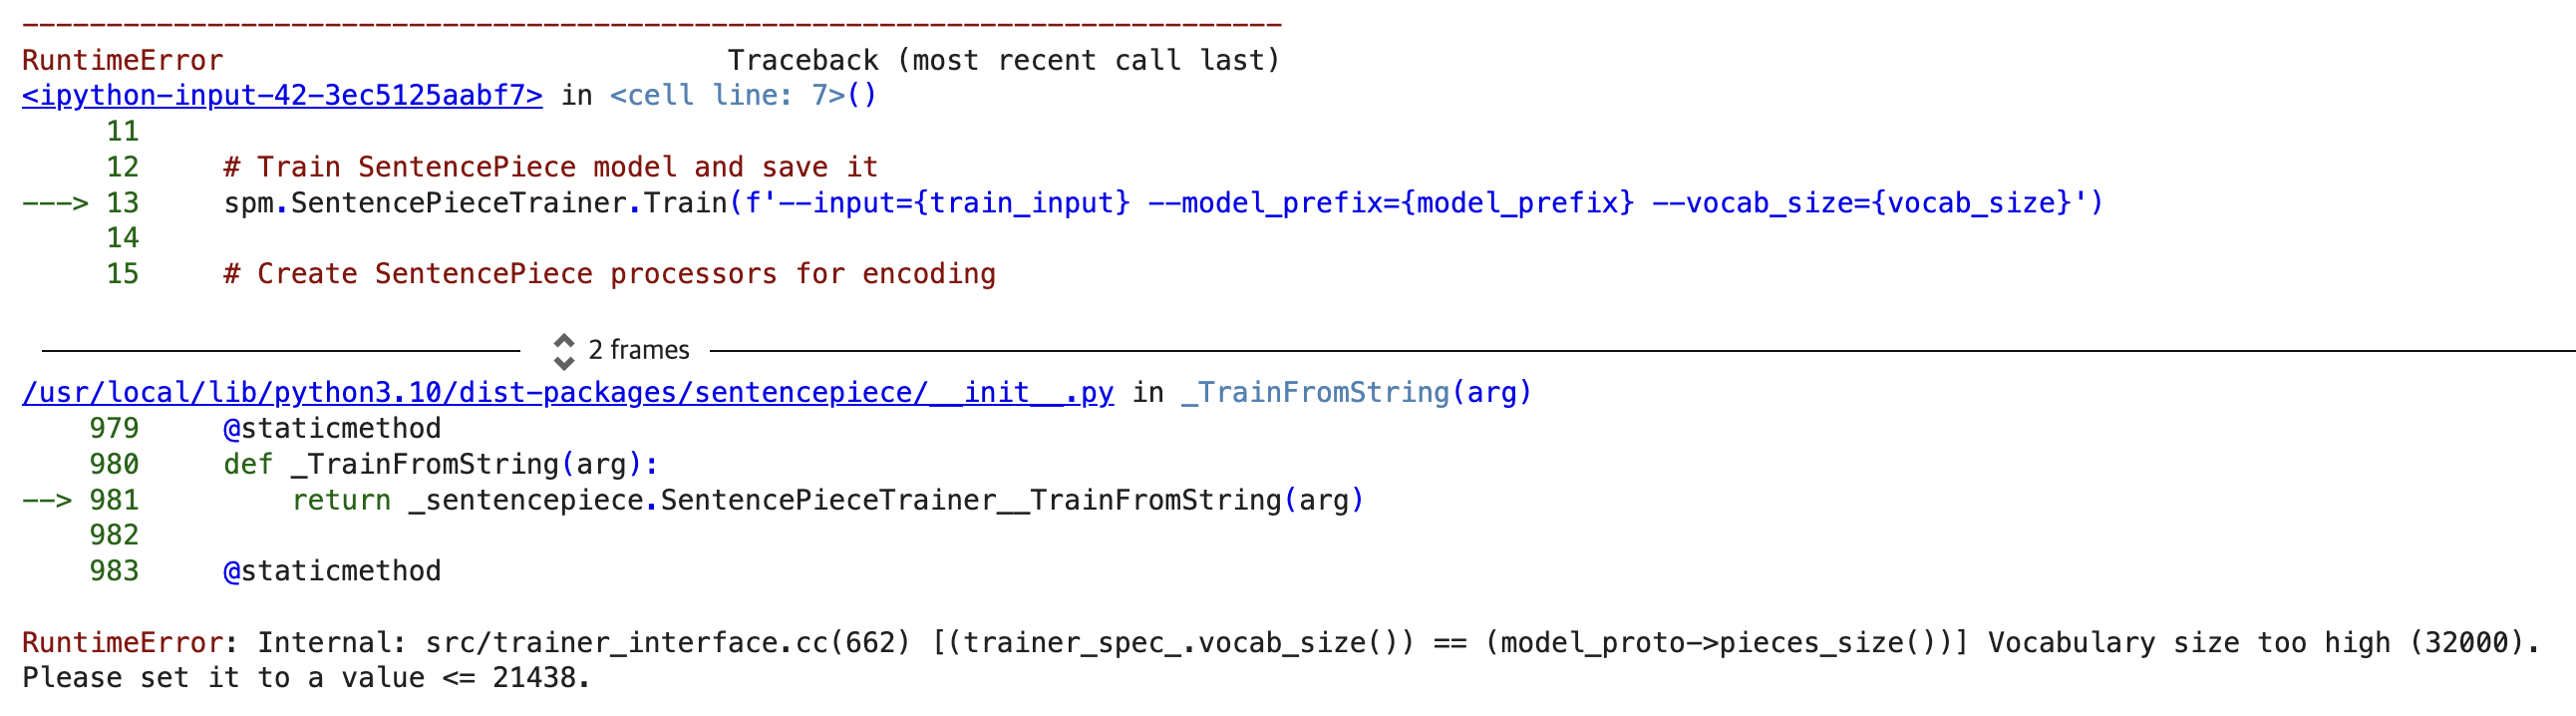

In [77]:
import sentencepiece as spm

# Define the vocabulary size
vocab_size = 21438

# Loop through each language and tokenize train and test datasets
for lang in languages:
    train_input = f'/content/drive/MyDrive/NLP/{lang}_train.txt'
    test_input = f'/content/drive/MyDrive/NLP/{lang}_test.txt'
    model_prefix = f'{lang}'  # Define the model prefix

    # Train SentencePiece model and save it
    spm.SentencePieceTrainer.Train(f'--input={train_input} --model_prefix={model_prefix} --vocab_size={vocab_size}')

    # Create SentencePiece processors for encoding
    sp = spm.SentencePieceProcessor()
    sp.Load(f'{model_prefix}.model')

    # Tokenize and save train dataset
    with open(f'/content/drive/MyDrive/NLP/{lang}_train_tokenized.txt', 'w', encoding='utf-8') as train_output:
        with open(train_input, 'r', encoding='utf-8') as train_input_file:
            for line in train_input_file:
                tokens = sp.EncodeAsPieces(line)
                train_output.write(' '.join(tokens) + '\n')

    # Tokenize and save test dataset
    with open(f'/content/drive/MyDrive/NLP/{lang}_test_tokenized.txt', 'w', encoding='utf-8') as test_output:
        with open(test_input, 'r', encoding='utf-8') as test_input_file:
            for line in test_input_file:
                tokens = sp.EncodeAsPieces(line)
                test_output.write(' '.join(tokens) + '\n')


In [78]:
data_dir="/content/drive/MyDrive/NLP"

for lang in languages:
  input_file= os.path.join(data_dir, f'{lang}_train_tokenized.txt')
  output_file = f'/content/drive/MyDrive/NLP/{lang}_train.arpa'

  cmd= f'./bin/lmplz -o 5 < {input_file} > {output_file}'
  os.system(cmd)

**27. Train a language model on these new datasets and compute the new perplexity. What can you conclude?**

- Models for fusional languages tend to have lower perplexities than those for other morphological types. When the vocabulary size is fixed (e.g., 32,000 tokens), the perplexity decreases for all languages, especially for morphologically rich languages like Korean, where perplexity drops significantly. The influence of TTR on perplexity diminishes when a fixed vocabulary size is used, and a more unified relationship between model performance and TTR across languages is observed. This consistency is beneficial for building NLP pipelines and models that perform well across diverse languages without significant discrepancies.

In [79]:
for lang in languages:
  model_path= f'/content/drive/MyDrive/NLP/{lang}_train.arpa'
  model=kenlm.Model(model_path)
  ppl_lang = 0
  nb_sentences = 0
  test_file = os.path.join("/content/drive/MyDrive/NLP/", f'{lang}_test_tokenized.txt')

  with open(test_file, 'r', encoding= 'utf-8') as file:
    test_sentences = file.readlines()
    for sentence in test_sentences:
      nb_sentences +=1
      ppl_sent = model.perplexity(sentence)
      ppl_lang+=ppl_sent

  ppl_lang= ppl_lang/nb_sentences
  df.loc[df['Lang_code'] == lang, 'Perplexity_BPE'] = ppl_lang

In [80]:
df

,Lang_code,TTR,Perplexity,Morphology,Perplexity_BPE
0,en,0.067503,1101.872424,Fusional,242.869992
1,ar,0.136828,3422.922598,Introflexive,460.203764
2,zh-cn,0.044721,1280.431786,Isolating,325.052478
3,zh-tw,0.052996,1393.025332,Isolating,315.191509
4,nl,0.098723,1173.39176,Fusional,244.180512
5,fr,0.082807,1180.755354,Fusional,180.916610
6,de,0.133760,1124.447952,Fusional,249.016368
7,it,0.087939,1729.800013,Fusional,210.812200
8,ja,0.046549,616.088398,Agglutinative,189.153096
9,ko,0.281317,6486.4469,Agglutinative,341.322979


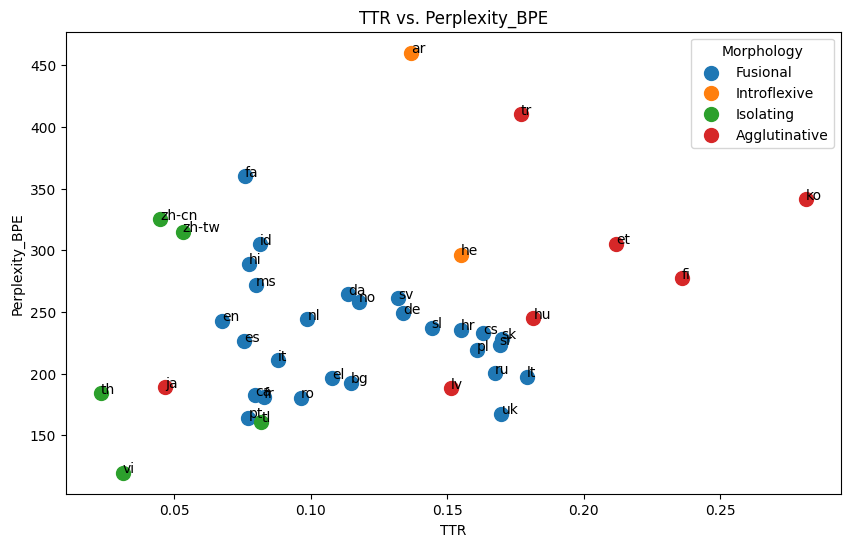

In [81]:
plt.figure(figsize=(10, 6))
for morphology in df['Morphology'].unique():
  subset = df[df['Morphology'] == morphology]
  plt.scatter(subset['TTR'], subset['Perplexity_BPE'], label=morphology, s=100)
  for i, txt in enumerate(subset['Lang_code']):
    plt.annotate(txt, (subset['TTR'].iloc[i], subset['Perplexity_BPE'].iloc[i]))

plt.xlabel('TTR')
plt.ylabel('Perplexity_BPE')
plt.title('TTR vs. Perplexity_BPE')
plt.legend(title='Morphology')
plt.grid(False)
plt.show()